## Clustering DTW_K-means

In [1]:
import yfinance as yf
import os
import zigzag
from zigzag import peak_valley_pivots
from zigzag import pivots_to_modes
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
from pandas_datareader.oecd import OECDReader
from yahooquery import Ticker
import warnings
import logging
from transformers import BertTokenizer, BertModel, logging as transformers_logging
from sklearn.neural_network import BernoulliRBM
import torch
import numpy as np
import pandas as pd
os.getcwd()

'/Users/xiaobinlu/pytorch-test/Stock_econ_company'

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)

companies = [
    "IBM", "AAPL", "JPM", "MSFT", "AMZN", "GOOGL", "GOOG", "NVDA", "TSLA",
    "META", "UNH", "V", "XOM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "MRK",
    "ABBV", "PEP", "KO", "AVGO", "COST", "TMO", "MCD", "CSCO", "NEE", "NKE", "ORCL",
    "TXN", "VZ", "PM", "ABT", "DHR", "ADBE", "CRM", "WFC", "ACN", "LIN", "NFLX",
    "UPS", "MS", "INTC", "RTX", "SCHW", "QCOM"
]


In [3]:
directory_path = "./US"

tickers_with_zero_splits_only = []
for ii in companies:
    filename = os.path.join(directory_path, ii + ".csv")  
    temp = pd.read_csv(filename)
    if not (temp['Stock Splits'] != 0.0).any():
        tickers_with_zero_splits_only.append(ii)
print(len(companies))
print(len(tickers_with_zero_splits_only))

49
38


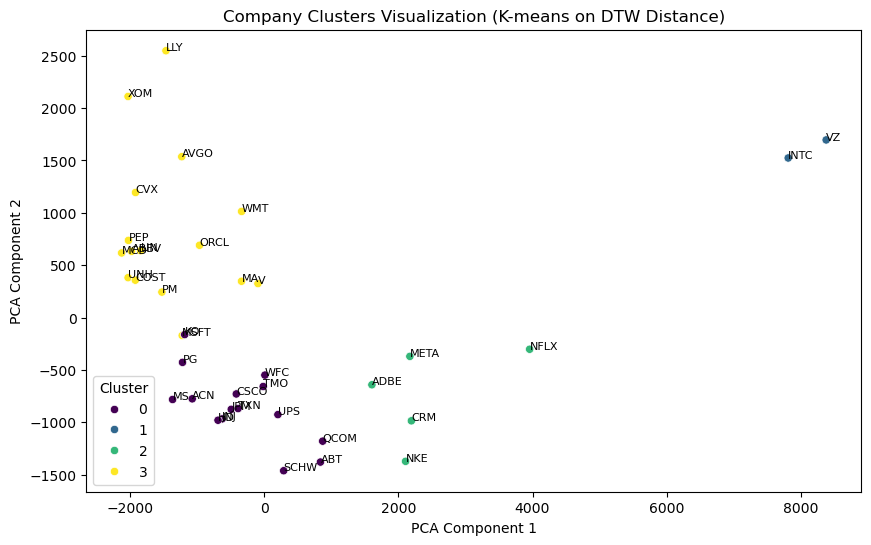

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def load_and_preprocess_data(ticker, data_dir='./US'):
    file_path = os.path.join(data_dir, f"{ticker}.csv")
    df = pd.read_csv(file_path)
    features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled

def compute_dtw_distance_matrix(tickers, data_dir='./US'):
    n = len(tickers)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            ts_i = load_and_preprocess_data(tickers[i], data_dir)
            ts_j = load_and_preprocess_data(tickers[j], data_dir)
            distance, _ = fastdtw(ts_i, ts_j, dist=euclidean)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

def kmeans_clustering(distance_matrix, n_clusters=3, n_init=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=n_init)
    kmeans.fit(distance_matrix)
    return kmeans.labels_

labels = kmeans_clustering(distance_matrix, n_clusters, n_init=10)

data_dir = './US'

distance_matrix = compute_dtw_distance_matrix(tickers_with_zero_splits_only, data_dir)

n_clusters = 4
labels = kmeans_clustering(distance_matrix, n_clusters)

feature_vectors_df = pd.DataFrame({
    'Company': tickers_with_zero_splits_only,
    'Cluster': labels
})

pca = PCA(n_components=2)
distance_matrix_2d = pca.fit_transform(distance_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=distance_matrix_2d[:, 0], y=distance_matrix_2d[:, 1], hue=feature_vectors_df['Cluster'], palette='viridis')
for i, txt in enumerate(feature_vectors_df['Company']):
    plt.annotate(txt, (distance_matrix_2d[i, 0], distance_matrix_2d[i, 1]), fontsize=8)
plt.title('Company Clusters Visualization (K-means on DTW Distance)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

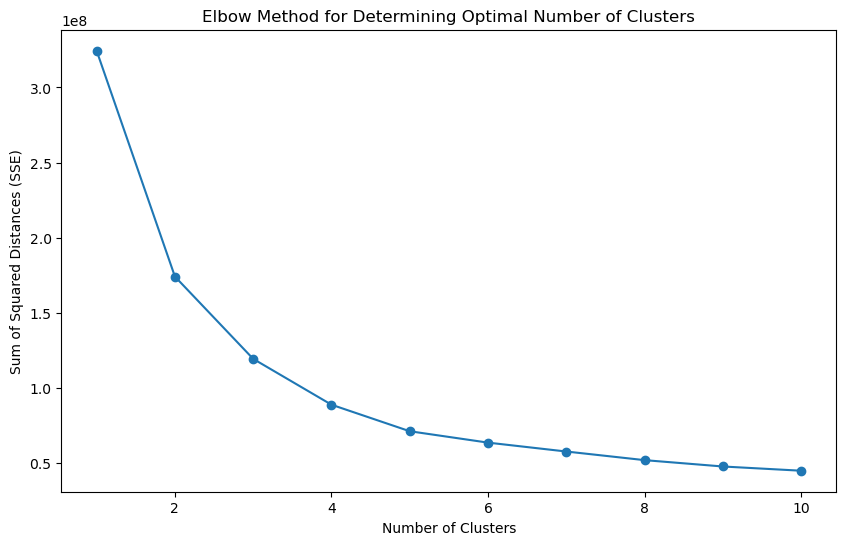

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def calculate_elbow(distance_matrix, max_clusters=10):
    sse = [] 
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(distance_matrix)
        sse.append(kmeans.inertia_) 
    return sse


data_dir = './US'


max_clusters = 10
sse = calculate_elbow(distance_matrix, max_clusters)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()
